In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.framework import ops
import random
import os

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
learning_rate = 0.001
training_steps = 10000
batch_size = 256
display_step = 200

In [5]:
num_input = 28 
timesteps = 28 
num_hidden = 128 
num_classes = 10

In [6]:
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

In [7]:
weights = {
    'out': tf.Variable(tf.random_normal([2*num_hidden, num_classes]))
}

In [8]:
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [9]:
def BiRNN(x, weights, biases):
    x = tf.transpose(x, [1, 0, 2])
    x = tf.reshape(x, [-1, num_input])
    x = tf.split(axis=0, num_or_size_splits=timesteps, value=x)
    lstm_fw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    lstm_bw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    try:
        outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                              dtype=tf.float32)
    except Exception: 
        outputs = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                        dtype=tf.float32)
    return tf.matmul(outputs[-1], weights['out']) + biases['out']


In [10]:
logits = BiRNN(X, weights, biases)
prediction = tf.nn.softmax(logits)

In [11]:
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

In [13]:
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [14]:
init_op = tf.global_variables_initializer()

In [15]:
loss_list = []
accuracy_list = []
step_list = []

In [16]:
with tf.Session() as sess:
    sess.run(init_op)
    print("Optimization started!")
    for step in range(1, training_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        batch_x = batch_x.reshape((batch_size, timesteps, num_input))
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
            loss_list.append(loss)
            accuracy_list.append(acc)
            step_list.append(step)
    print("Optimization Finished!")
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, timesteps, num_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))


Optimization started!
Step 1, Minibatch Loss= 2.5016, Training Accuracy= 0.211
Step 200, Minibatch Loss= 0.2118, Training Accuracy= 0.910
Step 400, Minibatch Loss= 0.0755, Training Accuracy= 0.980
Step 600, Minibatch Loss= 0.0805, Training Accuracy= 0.973
Step 800, Minibatch Loss= 0.0833, Training Accuracy= 0.980
Step 1000, Minibatch Loss= 0.0497, Training Accuracy= 0.988
Step 1200, Minibatch Loss= 0.0462, Training Accuracy= 0.984
Step 1400, Minibatch Loss= 0.0388, Training Accuracy= 0.984
Step 1600, Minibatch Loss= 0.0655, Training Accuracy= 0.965
Step 1800, Minibatch Loss= 0.0441, Training Accuracy= 0.984
Step 2000, Minibatch Loss= 0.0137, Training Accuracy= 0.996
Step 2200, Minibatch Loss= 0.0320, Training Accuracy= 0.988
Step 2400, Minibatch Loss= 0.0053, Training Accuracy= 1.000
Step 2600, Minibatch Loss= 0.0132, Training Accuracy= 0.992
Step 2800, Minibatch Loss= 0.0166, Training Accuracy= 0.996
Step 3000, Minibatch Loss= 0.0487, Training Accuracy= 0.984
Step 3200, Minibatch Loss

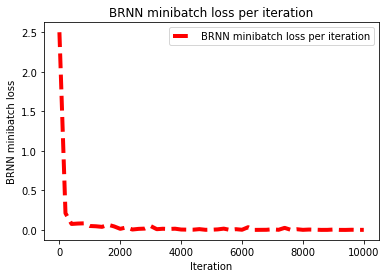

In [17]:
plt.plot(step_list, loss_list, 'r--', label='BRNN minibatch loss per iteration', linewidth=4)
plt.title('BRNN minibatch loss per iteration')
plt.xlabel('Iteration')
plt.ylabel('BRNN minibatch loss')
plt.legend(loc='upper right')
plt.show()

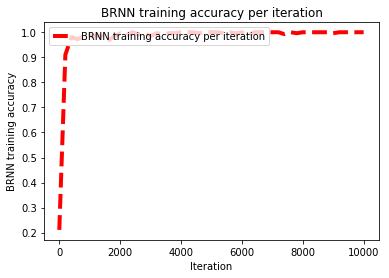

In [18]:
plt.plot(step_list, accuracy_list, 'r--', label='BRNN training accuracy per iteration', linewidth=4)
plt.title('BRNN training accuracy per iteration')
plt.xlabel('Iteration')
plt.ylabel('BRNN training accuracy')
plt.legend(loc='upper left')
plt.show()